# Running multiple models with BMI in one "Framework"
## Conceptual Functional Equivalent (CFE) Model
## Penman function for an estimate of evaporation
## Bucket model representing some downstream reservoir

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
#sys.path.insert(0, './PCFE')
import bmi_cfe_peturb
sys.path.insert(0, './Assimilation')
import bmi_assimilation


### Create an instance of the model with a specific configuration that corresponds to a particular catchmenmt.

In [2]:
print(bmi_cfe)
print(bmi_cfe_peturb)
print(bmi_assimilation)

<module 'bmi_cfe' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe.py'>
<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>
<module 'bmi_assimilation' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\bmi_assimilation.py'>


In [3]:
cfe_instance = bmi_cfe.BMI_CFE()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_assimilation = bmi_assimilation.BMI_Assimilation()

print(cfe_instance)
print(cfe_instance_peturb)
print(cfe_assimilation)

### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [4]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_assimilation.initialize()


In [10]:
print(cfe_instance.get_input_var_names())
print(cfe_instance_peturb.get_input_var_names())
print(cfe_assimilation.get_output_var_names())


['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
['USGS_DA']


### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [11]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
with open(cfe_instance_peturb.forcing_file, 'r') as file:
    df_forcing_peturb = pd.read_csv(file)
    
print(df_forcing_peturb)

                    time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0    2015-12-01 00:00:00           0.0     361.200012       0.000000   
1    2015-12-01 01:00:00           0.0     361.200012       0.000000   
2    2015-12-01 02:00:00           0.0     361.200012       0.000000   
3    2015-12-01 03:00:00           0.0     357.600006       0.000000   
4    2015-12-01 04:00:00           0.0     357.600006       0.000000   
..                   ...           ...            ...            ...   
715  2015-12-30 19:00:00           4.7     402.200012     163.600006   
716  2015-12-30 20:00:00           3.7     402.200012     130.300003   
717  2015-12-30 21:00:00           4.2     399.200012      80.400002   
718  2015-12-30 22:00:00           8.3     399.200012      21.000000   
719  2015-12-30 23:00:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0        100530.0              0.0105         287.5000

### We will want to visualize the model output

In [22]:
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

cfe_outputs_peturb=cfe_instance_peturb.get_output_var_names()
cfe_output_lists_peturb = {output_peturb:[] for output_peturb in cfe_outputs_peturb}

outputs_assimilation=cfe_assimilation.get_output_var_names()
outputs_lists_assimilation = {output_assimilation:[] for output_assimilation in outputs_assimilation}

print(cfe_output_lists)
print(cfe_output_lists_peturb)
print(outputs_lists_assimilation)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}
{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}
{'USGS_DA': []}


In [25]:
# Get output var values

usgs_obs = cfe_instance_peturb.get_value('land_surface_water__runoff_depth') 
cfe_model = cfe_instance.get_value('land_surface_water__runoff_depth') 
DA_output = cfe_assimilation.set_value('USGS_DA', cfe_model,usgs_obs)



# Watershed flows into some reservoir
#into_bucket = cfe_instance.get_value("land_surface_water__runoff_depth") #output of model that goes into reservoir
#bucket_instance.set_value('water__input_volume_flux', into_bucket)
#bucket_instance.set_value('water_potential_evaporation_flux', e/1000)
#bucket_instance.update() 
print(DA_output)

TypeError: set_value() takes 3 positional arguments but 4 were given

In [13]:
cfe_instance.get_current_time()
cfe_assimilation.get_current_time()

0

### Now we loop through the forcing data and use it to run the model at each time step

In [14]:
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run the hydrology model
    #cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', e)
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    
    for output in cfe_outputs:
        cfe_output_lists[output].append(cfe_instance.get_value(output))
        
#print(cfe_output_lists)
        
# Peturbation run   
for i2, precip2 in enumerate(df_forcing_peturb['APCP_surface']): #i is 
    
    framework_time = (1+i2)*3600 #seconds since starting simulation
   
    cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip2) #value of precip from forcing data in loop
    cfe_instance_peturb.update()
    
    for output_peturb in cfe_outputs_peturb:
        cfe_output_lists_peturb[output_peturb].append(cfe_instance_peturb.get_value(output_peturb))   
        
#print(cfe_output_lists_peturb)


### The finalize function should perform all tasks that take place after exiting the model’s time loop. This typically includes deallocating memory, closing files and printing reports.

In [16]:
cfe_instance.finalize(print_mass_balance=True)
cfe_instance_peturb.finalize(print_mass_balance=True)
#cfe_instance_assimilation.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.0000
    volume input:   0.0000
   volume output:   0.0000
    final volume:   0.8880
        residual: -1.1552e+01

SCHAAKE MASS BALANCE
  surface runoff:   0.0000
    infiltration:   0.0000
schaake residual: 0.0000e+00

GIUH MASS BALANCE
  vol. into giuh:   0.0000
   vol. out giuh:   0.0000
 vol. end giuh q:  10.6640
   giuh residual: -1.0664e+01

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.0000
  vol. into soil:   0.0000
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8780
vol. soil resid.: -8.7800e-01

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00

GLOBAL MASS BALANCE
  initial volume:   0.0000
    v

### Here we are just plotting the fluxes.

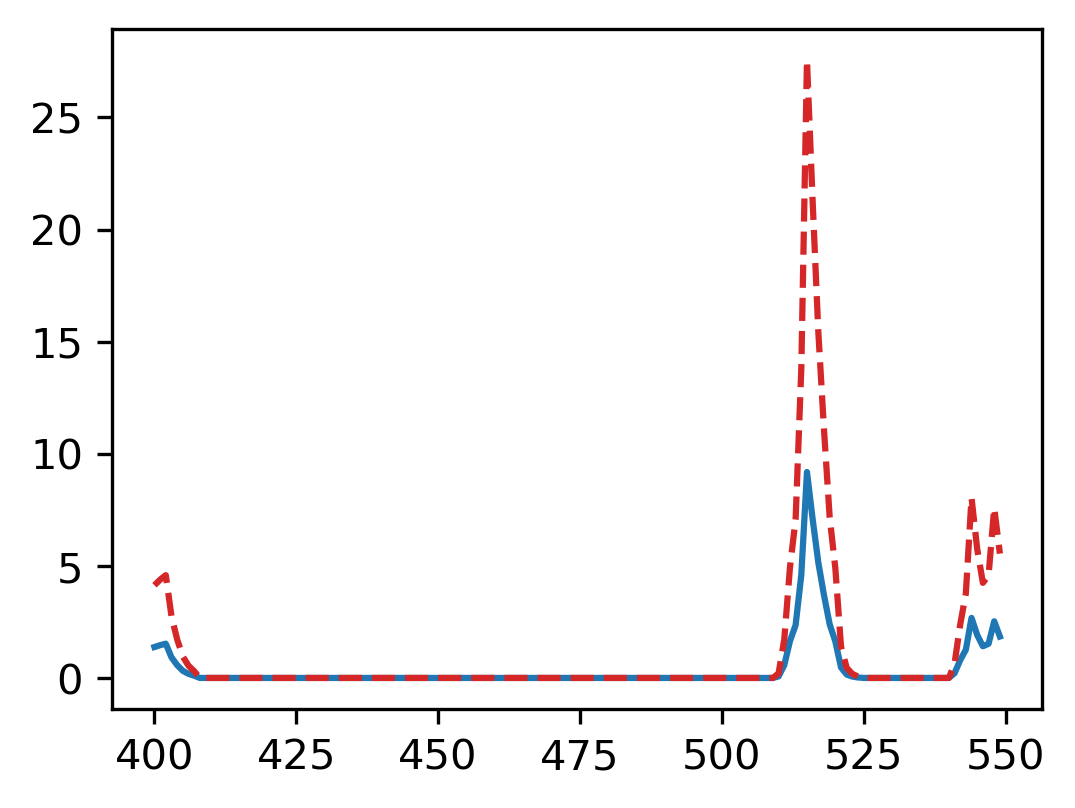

In [17]:
istart_plot=400
iend_plot=550
x = list(range(istart_plot, iend_plot))
#for output in cfe_outputs:
#    plt.plot(x, cfe_output_lists[output][istart_plot:iend_plot], label=output)
#    plt.title(output)
#    plt.legend()
#    plt.show()
#    plt.close()

fig = plt.figure(figsize = (4,3), dpi=300)
plt.plot(x, cfe_output_lists['land_surface_water__runoff_volume_flux'][istart_plot:iend_plot], color = 'tab:blue')
plt.plot(x, cfe_output_lists_peturb['land_surface_water__runoff_volume_flux'][istart_plot:iend_plot], color = 'tab:red', linestyle='dashed')


### Here we are just going to run the unit test that compares with the origional author code. Kind of the same thing done above, but there is a function in the BMI code that does it all at once.